In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 14, 8

In [2]:
data = pd.read_csv('datasets/malicious_urls.csv')
data.describe()

,url,type
count,663191,663191
unique,653040,5
top,http://style.org.hc360.com/css/detail/mysite/s...,benign
freq,180,428103


In [3]:
# Removing duplicates
data = data.drop_duplicates(subset='url')
data.describe()

,url,type
count,653040,653040
unique,653040,5
top,br-icloud.com.br,benign
freq,1,428080


In [4]:
data

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
663186,http://archive.salisburyjournal.co.uk/2001/3/7/,spam
663187,http://astore.amazon.co.uk/allezvinsfrenchr/de...,spam
663188,http://archive.thisischeshire.co.uk/2000/1/14/...,spam
663189,http://applerugs.co.uk/rugs/product_info.php?p...,spam


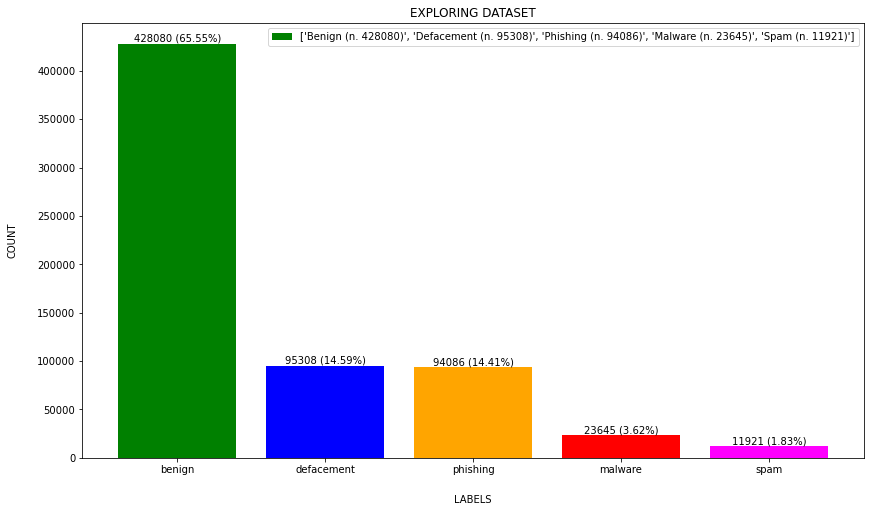

In [6]:
count = data.type.value_counts()
bar_labels = [count.index[i].capitalize()+' (n. ' + str(count[i]) + ')' for i in range(len(count.index))]
bars = plt.bar(count.index, height=count, label=bar_labels, color=['green', 'blue', 'orange', 'red', 'magenta'])

for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f} ({height/len(data)*100:.2f}%)', ha='center', va='bottom')

plt.xlabel('LABELS', labelpad=20)
plt.ylabel('COUNT', labelpad=20)
plt.title('EXPLORING DATASET')
plt.legend()
plt.show()

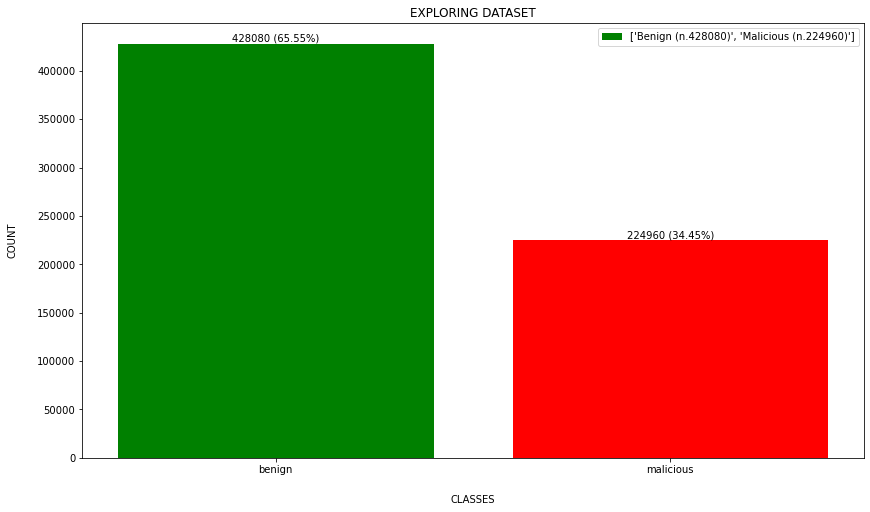

In [7]:
benign = count[0]
malicious = len(data) - benign
bar_labels = ['Benign (n.'+str(benign)+')', 'Malicious (n.'+str(malicious)+')']
bars = plt.bar(['benign', 'malicious'], height=[benign, malicious], label=bar_labels, color=['green', 'red'])

for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f} ({height/len(data)*100:.2f}%)', ha='center', va='bottom')

plt.xlabel('CLASSES', labelpad=20)
plt.ylabel('COUNT', labelpad=20)
plt.title('EXPLORING DATASET')
plt.legend()
plt.show()

In [9]:
benign_urls = data[data['type'] == 'benign'] 
drop_indices = np.random.choice(benign_urls.index, 274545, replace=True)
data_equalized = data.drop(drop_indices)

In [11]:
data.to_csv('datasets/malicious_url_balanced.csv', index=False)

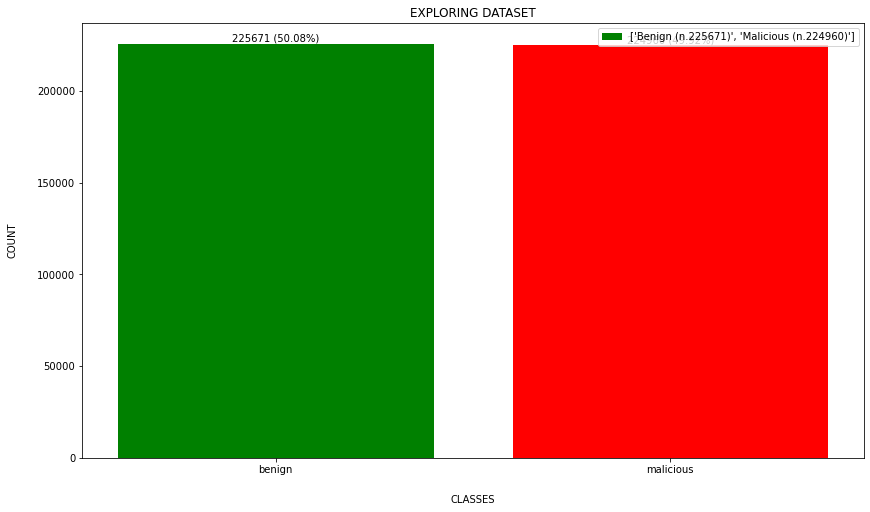

In [12]:
count = data_equalized.type.value_counts()
benign = count[0]
malicious = len(data_equalized) - benign
bar_labels = ['Benign (n.'+str(benign)+')', 'Malicious (n.'+str(malicious)+')']
bars = plt.bar(['benign', 'malicious'], height=[benign, malicious], label=bar_labels, color=['green', 'red'])

for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f} ({height/len(data_equalized)*100:.2f}%)', ha='center', va='bottom')

plt.xlabel('CLASSES', labelpad=20)
plt.ylabel('COUNT', labelpad=20)
plt.title('EXPLORING DATASET')
plt.legend()
plt.show()